In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from IPython.display import SVG
import sknetwork as skn
from sklearn.metrics import adjusted_mutual_info_score as AMI


# Toy Dataset

The graph represents links between 30 wikipedia pages, 10 each from topics: science, art or philosophy.
There is a feature vector for each page, each feture representing a keyword count.

* `A`: csr adjacency matrix, directed (30 nodes)
* `names`: name of each node (wikipedia page); we also define `names_dict` for quick reference
* `features`: csr matrix of binary features
* `name_features`: name of each feature (11 keywords)
* `labels`: numpy array, node label (0, 1 or 2)
* `name_labels`: name of the labels (category of page: science, art or philosophy)


In [2]:
from sknetwork.data import art_philo_science

graph = art_philo_science(metadata=True)
A = graph.adjacency
features = graph.biadjacency
names = graph.names
names_dict = {v:k for k,v in enumerate(names)}
names_features = graph.names_col
names_labels = graph.names_labels
labels = graph.labels
layout = graph.position


## Visualization - directed graph and features

In [3]:
from sknetwork.embedding import Spring, SVD
from sknetwork.visualization import svg_graph, svg_bigraph

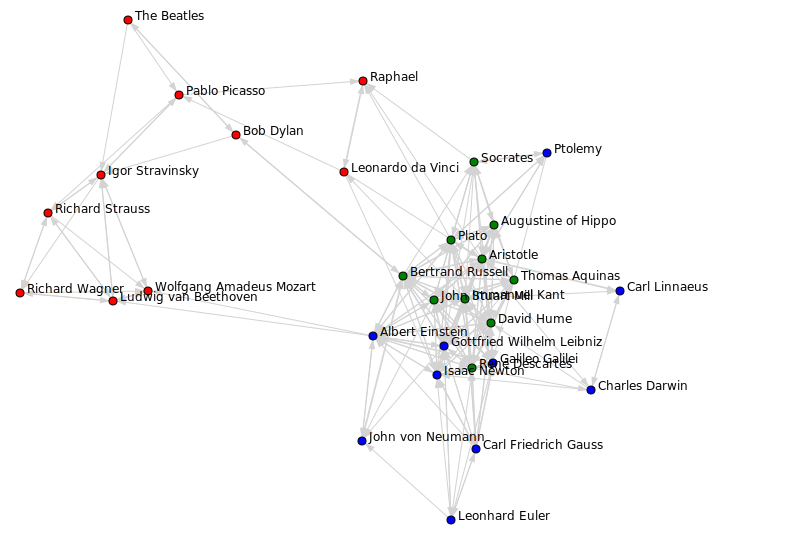

In [4]:
layout = Spring(2, position_init='spectral').fit_transform(A)
image = svg_graph(A, names=names, position=layout, width=600, height=500, labels=labels,
                  node_size=4, edge_color='lightgray')
SVG(image)

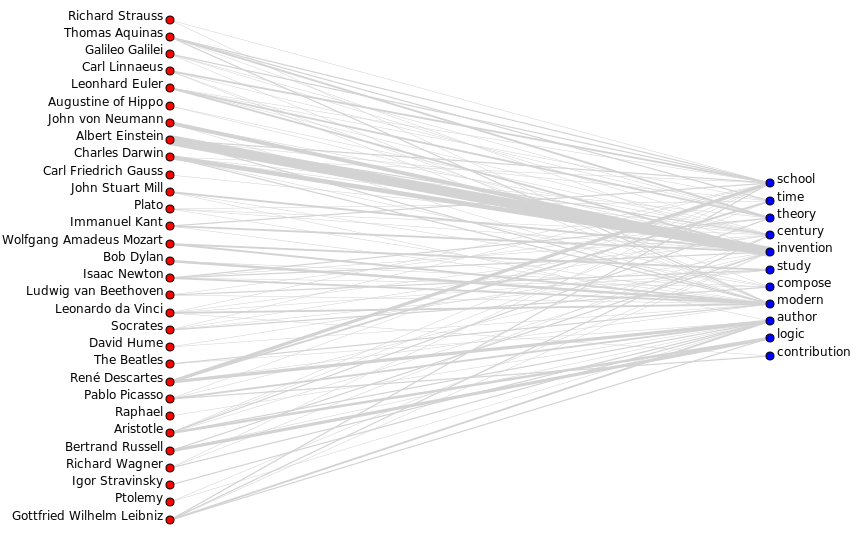

In [5]:
image = svg_bigraph(features, names_row=names, names_col=names_features, width=600, height=500, 
                    color_row='red', color_col='blue', node_size=4, edge_color='lightgray')
SVG(image)


## EDA -- centrality

In [6]:
from sknetwork.ranking import PageRank, Betweenness, HITS
from sknetwork.utils import get_degrees, get_weights


In [7]:
## in/out degree, total degree
out_deg = get_degrees(A)
in_deg = get_degrees(A, transpose=True)
deg = out_deg + in_deg
top_deg = deg.argsort()[::-1]

## top total degree nodes
print(names[top_deg[:3]])


['Aristotle' 'Bertrand Russell' 'Plato']


In [8]:
## top PageRank 
pagerank = PageRank()
top_pr = pagerank.fit_predict(A).argsort()[::-1]
print(names[top_pr[:3]])


['Wolfgang Amadeus Mozart' 'Ludwig van Beethoven' 'Aristotle']


In [9]:
## top Betweenness 
between = Betweenness()
top_bet = between.fit_predict(A).argsort()[::-1]
print(names[top_bet[:3]])


['Leonardo da Vinci' 'Aristotle' 'Raphael']


In [10]:
## personalized PageRank - top nodes given 1+ seed nodes
seeds = {'Aristotle','Socrates'}
indices = [k for k,v in enumerate(names) if v in seeds]
weights = {x:1 for x in indices}
top_ppr = pagerank.fit_predict(A, weights).argsort()[::-1]
print(names[top_ppr[:3]])


['Aristotle' 'Socrates' 'Plato']


In [11]:
## top hub/authority scores
hits = HITS()
top_hub = hits.fit_predict(A).argsort()[::-1]
top_auth = hits.fit_predict(A.transpose()).argsort()[::-1]
print('top hub:',names[top_hub[:3]])
print('top authority:',names[top_auth[:3]])


top hub: ['Immanuel Kant' 'Aristotle' 'David Hume']
top authority: ['René Descartes' 'Aristotle' 'David Hume']


## Shortest paths

We look at the number of hops in the shortest path, either **from** source node(s) or **to** destination node(s).

We also look at the undirected version.


In [12]:
from sknetwork.path import get_distances, get_shortest_path
from sknetwork.utils import directed2undirected


In [13]:
## path length FROM the source
seed = 'Leonhard Euler'
source = np.where(names==seed)[0][0]
distances = get_distances(A, source)
print(Counter(distances))

## which nodes are furthest away
print('furthest nodes:',names[distances == max(distances)])

Counter({2: 11, 3: 7, 1: 6, 4: 5, 0: 1})
furthest nodes: ['Richard Wagner' 'Igor Stravinsky' 'The Beatles' 'Richard Strauss'
 'Pablo Picasso']


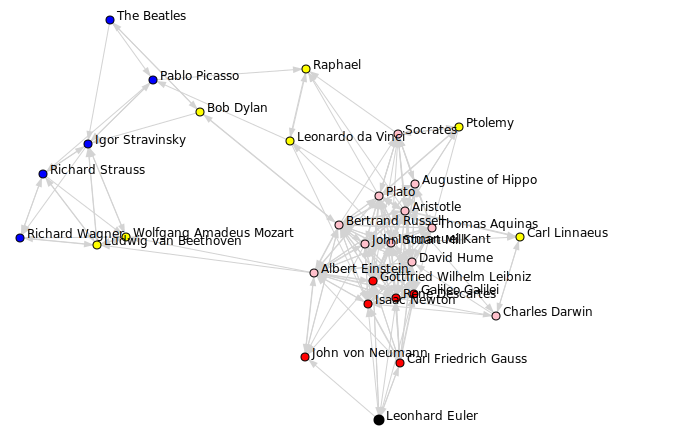

In [14]:
## color w.r.t. distance from seed node
image = svg_graph(A, names=names, position=layout, width=500, height=400, seeds=source,
                  labels=distances, node_size=4, node_order = np.argsort(-distances),
                  label_colors=['black','red','pink','yellow','blue'],
                  edge_color='lightgray', display_edge_weight=False)
SVG(image)


In [15]:
## path length TO the destination
seed = 'Leonhard Euler'
dest = np.where(names==seed)[0][0]
distances = get_distances(A.transpose(), dest)
print(Counter(distances))

## which nodes are furthest away
print('furthest nodes:',names[distances >= max(distances)-1])

Counter({2: 12, 3: 7, 7: 3, 1: 2, 4: 2, 0: 1, 8: 1, 6: 1, 5: 1})
furthest nodes: ['Richard Wagner' 'Ludwig van Beethoven' 'Wolfgang Amadeus Mozart'
 'Richard Strauss']


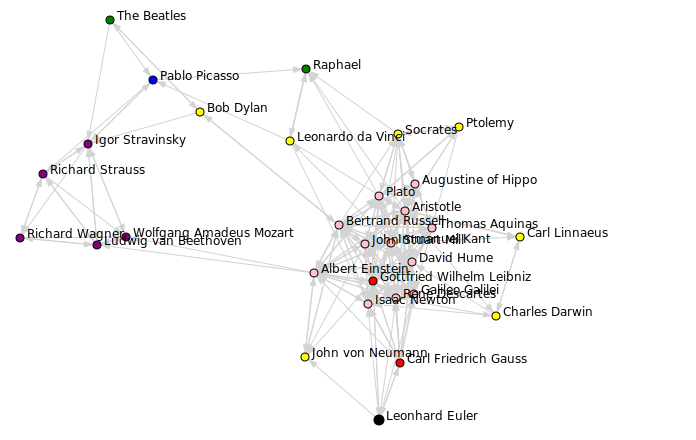

In [16]:
## color w.r.t. distance to seed node
image = svg_graph(A, names=names, position=layout, width=500, height=400, seeds=dest,
                  labels=distances, node_size=4, node_order = np.argsort(-distances),
                  label_colors=['black','red','pink','yellow','green','blue','purple','purple','purple'],
                  edge_color='lightgray', display_edge_weight=False)
SVG(image)


## Clustering


In [17]:
from sknetwork.clustering import Louvain
 

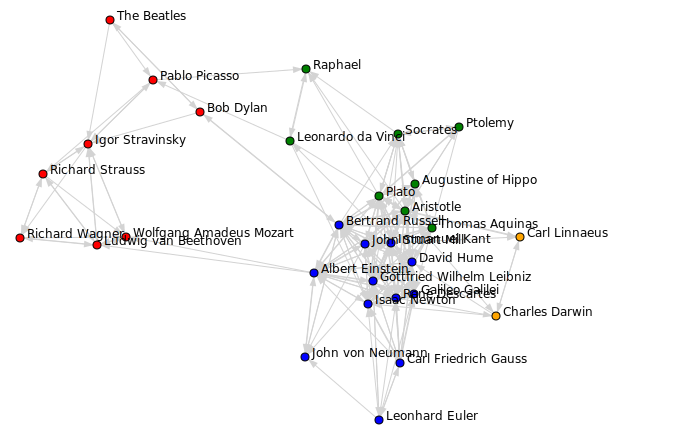

In [18]:
louvain = Louvain(shuffle_nodes=True, resolution=1.0)
labels_pred = louvain.fit_predict(A)
image = svg_graph(A, names=names, position=layout, width=500, height=400, 
                  labels=labels_pred, node_size=4, edge_color='lightgray', display_edge_weight=False)
SVG(image)


In [19]:
AMI(labels,labels_pred)

0.4424585757553337

### igraph - several other clustering algorithms

In [20]:
import igraph as ig
import partition_igraph

In [21]:
## igraph graph given adjacency
A_und = directed2undirected(A)
g = ig.Graph.Adjacency(A_und, 'undirected')

## run a few other clustering algorithms
ecg = g.community_ecg(final='leiden', ens_size=20, refuse_score=True)
ecg_class = ecg.membership
infomap_class = g.community_infomap().membership
leiden_class = g.community_leiden(objective_function='modularity').membership


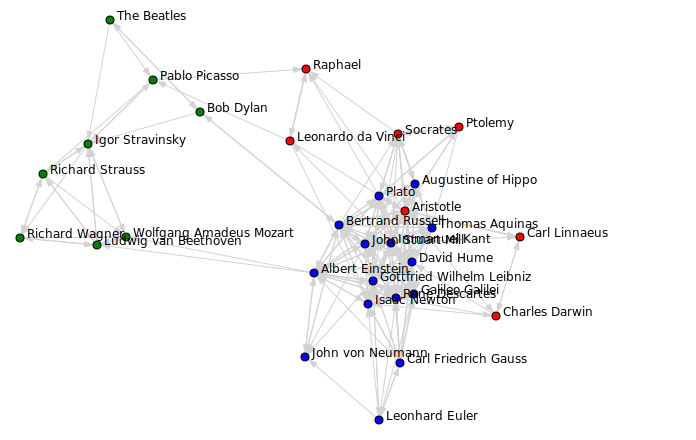

In [22]:
## Leiden
image = svg_graph(A, names=names, position=layout, width=500, height=400, 
                  labels=leiden_class, node_size=4, edge_color='lightgray', display_edge_weight=False)
SVG(image)


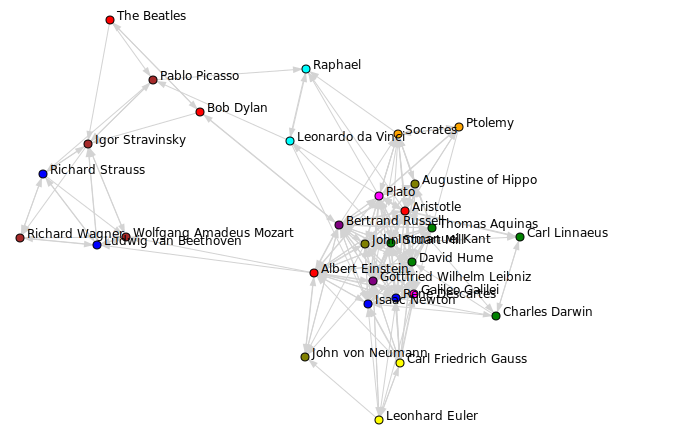

In [23]:
## infomap
image = svg_graph(A, names=names, position=layout, width=500, height=400, 
                  labels=infomap_class, node_size=4, edge_color='lightgray', display_edge_weight=False)
SVG(image)


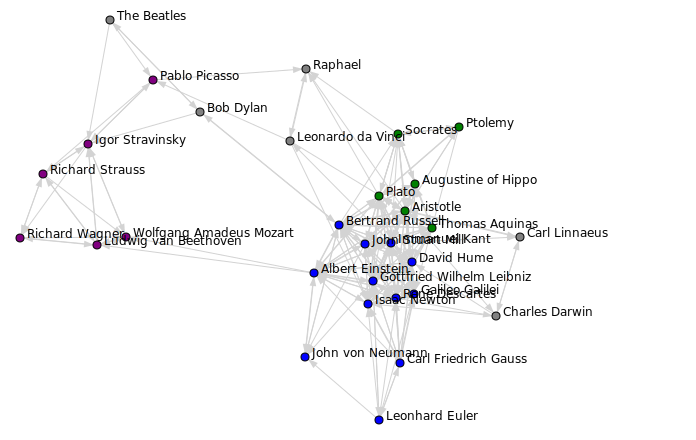

In [24]:
## ECG with 'refuse to cluster' option
ecg_refuse = np.array(ecg_class)
ecg_refuse[np.array(ecg.refuse_overall) > .67] = -1
ctr = Counter(ecg_refuse)
drop = [k for k in ctr.keys() if k>=0 and ctr[k]<=2]
for d in drop:
    ecg_refuse[ecg_refuse==d]=-1
image = svg_graph(A, names=names, position=layout, width=500, height=400, 
                  labels=ecg_refuse, node_size=4, edge_color='lightgray', display_edge_weight=False)
SVG(image)


## Semi-supervised learning

In [25]:
from sknetwork.classification import PageRankClassifier, get_accuracy_score

In [26]:
## fix (ground-truth) labels for a few seed nodes, and learn the other labels
seeds = ['Socrates', 'Thomas Aquinas', 'Galileo Galilei', 'Leonhard Euler',
         'Richard Strauss', 'The Beatles']
labels_ssl = {names_dict[x]:labels[names_dict[x]] for x in seeds}

## classifier
pr = PageRankClassifier()
labels_pred = pr.fit_predict(A, labels_ssl)
print('accuracy:',get_accuracy_score(labels, labels_pred))

accuracy: 0.6666666666666666


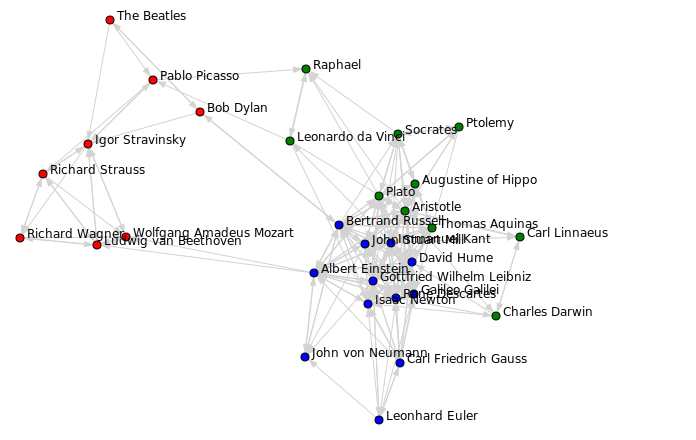

In [27]:
image = svg_graph(A, names=names, position=layout, width=500, height=400, 
                  labels=labels_pred, node_size=4, edge_color='lightgray', 
                  display_edge_weight=False)
SVG(image)

In [28]:
from ipywidgets import interact
import cairosvg
from PIL import Image
from io import BytesIO


In [29]:
def plot_ssl(threshold=0.5):
    labs = labels_pred.copy()
    proba = np.max(pr.predict_proba(),axis=1)
    labs[proba <= threshold] = -1
    image = svg_graph(A, position=layout, width=500, height=400, 
                      labels=labs, node_size=5, edge_color='lightgray', 
                      display_edge_weight=False)
    img_png = cairosvg.svg2png(image, dpi=600, scale=3)
    img = Image.open(BytesIO(img_png))
    plt.figure(figsize = (8,6))
    plt.imshow(img, interpolation='nearest')
    plt.axis('off')

In [30]:
interactive_plot = interact(plot_ssl, threshold=(0,1,.02));
interactive_plot;

interactive(children=(FloatSlider(value=0.5, description='threshold', max=1.0, step=0.02), Output()), _dom_cla…

## GNN -- classification


In [31]:
from scipy.sparse import hstack
from sknetwork.gnn import GNNClassifier as GNN


In [32]:
# Training set
labels_train = labels.copy()
train_mask = np.random.random(size=len(labels_train)) < 0.3 ## keep 30% for testing
labels_train[train_mask] = -1 ## negative labels are ignored in training


In [33]:
# GNN classifier with a single hidden layer
hidden_dim = 5
n_labels = 3

gnn = GNN(dims=[hidden_dim, n_labels],
                layer_types='Conv',
                activations='ReLu',
                verbose=True)

## for node features, we try: the unweighted adjacency matrix
node_features = hstack((A,features))
gnn_pred = gnn.fit_predict(A, node_features, labels=labels_train, 
                           n_epochs=100, random_state=42, history=True)


In epoch   0, loss: 1.202, train accuracy: 0.409
In epoch  10, loss: 0.943, train accuracy: 0.727
In epoch  20, loss: 0.681, train accuracy: 0.864
In epoch  30, loss: 0.628, train accuracy: 0.955
In epoch  40, loss: 0.605, train accuracy: 1.000
In epoch  50, loss: 0.588, train accuracy: 1.000
In epoch  60, loss: 0.576, train accuracy: 1.000
In epoch  70, loss: 0.568, train accuracy: 1.000
In epoch  80, loss: 0.562, train accuracy: 1.000
In epoch  90, loss: 0.559, train accuracy: 1.000


In [34]:
## test set accuracy
get_accuracy_score(labels[train_mask], gnn_pred[train_mask])


0.75

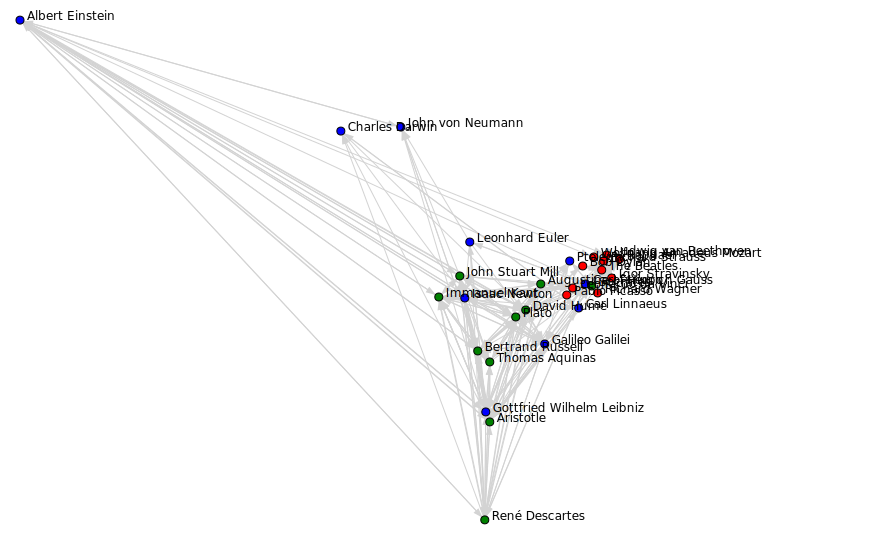

In [35]:
svd = SVD(2)
emb = svd.fit_transform(node_features)
image = svg_graph(A, names=names, position=emb, width=600, height=500, labels=labels,
                  node_size=4, edge_color='lightgray')
SVG(image)



## undirected

In [36]:
from sknetwork.utils import directed2undirected
from sknetwork.topology import get_core_decomposition as coreness
A_und = directed2undirected(A)
core = coreness(A_und)

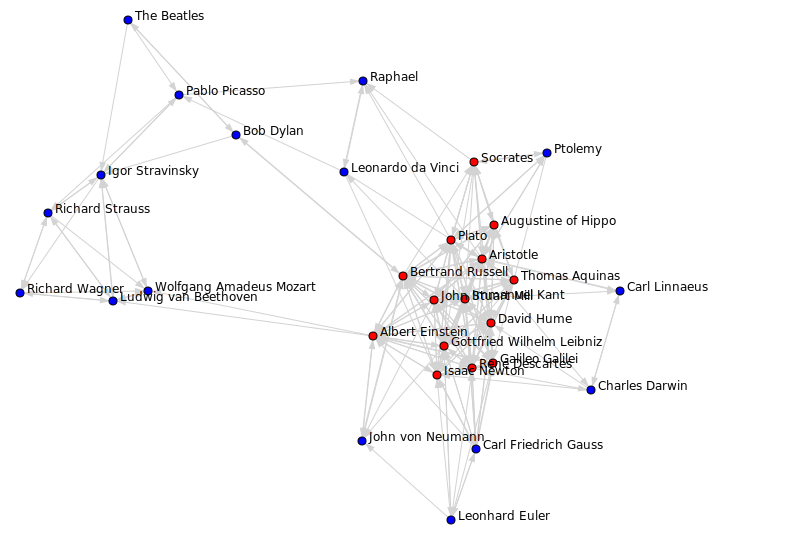

In [37]:
image = svg_graph(A, names=names, position=layout, width=600, height=500, labels=(core==max(core)),
                  node_size=4, edge_color='lightgray')
SVG(image)


### triangles

In [38]:
from sknetwork.topology import count_triangles, get_clustering_coefficient, count_cliques


In [39]:
print(count_triangles(A_und), count_cliques(A_und, clique_size=3),
      count_cliques(A_und, clique_size=10), get_clustering_coefficient(A_und))


335 335 5 0.6735924932975871


## scalable?

trying Louvain on 1M nodes

```
seed = "42"                   # RNG seed, use "" for no seeding
n = "1000000"                   # number of vertices in graph
t1 = "3"                      # power-law exponent for degree distribution
d_min = "5"                   # minimum degree
d_max = "200"                  # maximum degree
d_max_iter = "1000"           # maximum number of iterations for sampling degrees
t2 = "2"                      # power-law exponent for cluster size distribution
c_min = "500"                  # minimum cluster size
c_max = "10000"                # maximum cluster size
c_max_iter = "1000"           # maximum number of iterations for sampling cluster sizes
# Exactly one of xi and mu must be passed as Float64. Also if xi is provided islocal must be set to false or omitted.
xi = "0.2"                    # fraction of edges to fall in background graph
#mu = "0.2"                   # mixing parameter
islocal = "false"             # if "true" mixing parameter is restricted to local cluster, otherwise it is global
isCL = "false"                # if "false" use configuration model, if "true" use Chung-Lu
degreefile = "deg.dat"        # name of file do generate that contains vertex degrees
communitysizesfile = "cs.dat" # name of file do generate that contains community sizes
communityfile = "com.dat"     # name of file do generate that contains assignments of vertices to communities
networkfile = "edge.dat"      # name of file do generate that contains edges of the generated graph
nout = "0"                  # number of vertices in graph that are outliers; optional parameter
```


In [40]:
%%time
ABCD = skn.data.from_csv('./edge.dat', sep='\t', directed=False)


CPU times: user 7.22 s, sys: 1.6 s, total: 8.82 s
Wall time: 8.78 s


In [41]:
%%time
ABCD_ml = Louvain()
comm_ml = ABCD_ml.fit_predict(ABCD.adjacency)


CPU times: user 8.69 s, sys: 247 ms, total: 8.94 s
Wall time: 8.93 s


In [42]:
%%time
comm = pd.read_csv('./com.dat', sep='\t', header=None)[1]
AMI(comm, comm_ml)

CPU times: user 16.2 s, sys: 21 ms, total: 16.3 s
Wall time: 16.2 s


0.9650491700935074

In [43]:
%%time
G = ig.Graph.Read_Ncol('./edge.dat', directed=False)


CPU times: user 5.1 s, sys: 116 ms, total: 5.21 s
Wall time: 5.19 s


In [44]:
%%time
G.vs['ml']= G.community_multilevel().membership


CPU times: user 5min 34s, sys: 642 ms, total: 5min 35s
Wall time: 5min 34s


In [45]:
%%time
G.vs['gt'] = [comm[int(i)-1] for i in G.vs['name']]
AMI(G.vs['gt'],G.vs['ml'])

CPU times: user 17.8 s, sys: 23.5 ms, total: 17.8 s
Wall time: 17.8 s


0.9607305274925322

# TLoG - Undirected Graph

$
G = (V,E),~ |V|=n \\
W = (w_{ij} \ge 0)_{i,j = 1,...,n} \\
d_i = \sum_j w_{ij} \\
D = diag(d_1,...,d_n). 
$

For a partition $V = S \cup S^c$:

$$ Ncut(S,S^c) = \frac{Vol \partial S}{Vol S}  + \frac{Vol \partial S}{Vol S^c} $$

where:

$
\partial S = \{e \in E ; |e \cap S| = |e \cap S^c| = 1 \} \\
Vol(S) = \sum_{v \in S} d(v), \\
Vol(\partial S) = \sum_{(v_i, v_j) \in \partial S} w_{ij}.
$

Random walk view:

$$P = D^{-1}W, ~~ Ncut(S,S^c) = P(S|S^c) + P(S^c|S)$$.

The problem can be solved by relaxing over real values:

$$ f^* = \underset{f \in \mathbb{R}^n}{\operatorname{argmin}} f^t \Delta f,~ f \perp D^{1/2} \cdot 1,~ ||f||^2 = 1. $$
where:
$$ \Delta = I - D^{-1/2} W D^{-1/2} $$
the (normalized) graph Laplacian.

$
f^* = \underset{f \in H(V)}{\operatorname{argmin}} \left( \Omega(f) + {\mu} ||f-y||^2
\right) \\
\Omega(f) = <f^t, \Delta f> = \frac{1}{2} \sum_{(v_i,v_j) \in E} w_{ij} \left(\frac{f(v_i)}{\sqrt{d_i}} + \frac{f(v_j)}{\sqrt{d_j}}\right)^2
$

$y$ is a given vector of initial labels, typically $y_i \in {-1,0,1}$.

The solution is given by:
$
f^* = (1-\alpha)(I-\alpha S)^{-1}y,~ \alpha=(1+\mu)^{-1},~ S = I - \Delta. 
$


In [46]:
from scipy.sparse.linalg import cg, inv
from math import sqrt
from scipy.sparse import csr_matrix, diags, identity, rand
## Input: 
##   W: adjacency -- weighted triangular matrix
##   y: initial (seed) values
## Output:
##   x: solution of regularization problem via CG or (slow) explicit matrix inversion
def TLoG_und(W, y, alpha=0.5, inverse=False):
    ## undirected -- make W symmetric
    W = W+W.transpose()
    ## build D^{-1/2}, diagonal
    d = np.array(W.sum(axis=0))[0]
    d = [[1/sqrt(d[i]) for i in range(d.shape[0])]]
    D = diags(d, offsets=[0])
    ## Smothness matrix (here for undirected graph):
    ## S = D^{1/2} * W * D^{-1/2}
    S = D * W * D
    ## M = I - alpha*S
    n = W.shape[0]
    I = identity(n)
    M = I - alpha*S
    if(inverse):
        ## Inverse matrix
        Minv = inv(M)
        x = Minv * y    
    else:
        ## Conj. gradient
        x = cg(M,y)[0]       
    return(x)


In [47]:
## fix (correct) labels for a few seed nodes, and learn the other labels
seeds = ['Socrates', 'Thomas Aquinas', 'Galileo Galilei', 'Leonhard Euler',
         'Richard Strauss', 'The Beatles']
labels_ssl = {names_dict[x]:labels[names_dict[x]] for x in seeds}
labels_ssl

{29: 2, 23: 2, 7: 0, 8: 0, 17: 1, 15: 1}

In [48]:
y = np.repeat(0,A_und.shape[0])
y[29] = y[23] = 1 ## philophers as positive class
y[7] = y[8] = -1  ## scientists as negative

In [49]:
tl = TLoG_und(A_und, y)
lab = np.argsort(tl)
th = .01
for i in lab:
    if tl[i] > th:
        print("\033[1;31m"+names[i]+' : '+str(tl[i]))
    else:
        if tl[i] < -th:
            print("\033[1;34m"+names[i]+' : '+str(tl[i]))
        else:
            print("\033[1;32m"+names[i]+' : '+str(tl[i]))


Leonhard Euler : -1.061701588712835
Galileo Galilei : -1.041907027187313
Carl Friedrich Gauss : -0.15750185861792204
John von Neumann : -0.07134978199619967
Isaac Newton : -0.05919364673626207
Albert Einstein : -0.048455056151802026
René Descartes : -0.03143042306657292
Gottfried Wilhelm Leibniz : -0.002763545422156273
Wolfgang Amadeus Mozart : -0.0019469701192246635
Ludwig van Beethoven : -0.0017690664727028071
Richard Wagner : -0.0002787806006532131
Richard Strauss : 0.00019936468947421735
Igor Stravinsky : 0.0007354450443507989
Charles Darwin : 0.0008632786987403078
The Beatles : 0.0013482408722419099
Bob Dylan : 0.0028388487416957492
Carl Linnaeus : 0.006224376993370115
Pablo Picasso : 0.0064846439269770914
Leonardo da Vinci : 0.011954106313051906
David Hume : 0.02768822926407524
Immanuel Kant : 0.027897630038114435
Bertrand Russell : 0.02989773590817986
John Stuart Mill : 0.03376263851478215
Raphael : 0.06293665820780836
Aristotle : 0.06306043343215754
Plato : 0.0660263361018157
P